# Multivariate Time Series Prediction using MLP and RNN

https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [85]:
# import energy data
energy = pd.read_csv("energy_dataset.csv")
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [86]:
# only get the time and total load actual columns
energy = energy[["time", "total load actual"]]
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB


In [87]:
# import weather data
weather = pd.read_csv("weather_features.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [88]:
# non-numerical data would require one-hot encoding to fit into the model, which can be something to add in future work, here they are deleted for simplicity
# also delete measurements other than temperature and humidity, to make sure the dataset size is manageable after sliding window
weather = weather.drop(["pressure", "snow_3h","temp_min", "rain_3h", "rain_1h", "temp_max", "wind_speed", "wind_deg", "clouds_all", "weather_id", "weather_main", "weather_description", "weather_icon"], axis=1)

# since there are weather measurements from 4 different cities for each timestamp, take the average of the 4 cities 
weather = weather.groupby(['dt_iso']).mean()

weather

,temp,humidity
dt_iso,,
2015-01-01 00:00:00+01:00,272.491463,82.4
2015-01-01 01:00:00+01:00,272.512700,82.4
2015-01-01 02:00:00+01:00,272.099137,82.0
2015-01-01 03:00:00+01:00,272.089469,82.0
2015-01-01 04:00:00+01:00,272.145900,82.0
...,...,...
2018-12-31 19:00:00+01:00,284.470000,73.6
2018-12-31 20:00:00+01:00,282.294000,68.0
2018-12-31 21:00:00+01:00,280.850000,71.4


In [89]:
DENOISE = True

In [90]:
# combine the two dataframes based on the common timestamp
df = weather.merge(energy, left_on='dt_iso', right_on='time', suffixes=None)

# delete row with missing value
df = df.dropna()

df


/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/frame.py:8195: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return merge(


,temp,humidity,time,total load actual
0,272.491463,82.4,2015-01-01 00:00:00+01:00,25385.0
1,272.512700,82.4,2015-01-01 01:00:00+01:00,24382.0
2,272.099137,82.0,2015-01-01 02:00:00+01:00,22734.0
3,272.089469,82.0,2015-01-01 03:00:00+01:00,21286.0
4,272.145900,82.0,2015-01-01 04:00:00+01:00,20264.0
...,...,...,...,...
35059,284.470000,73.6,2018-12-31 19:00:00+01:00,30653.0
35060,282.294000,68.0,2018-12-31 20:00:00+01:00,29735.0
35061,280.850000,71.4,2018-12-31 21:00:00+01:00,28071.0
35062,279.718000,70.0,2018-12-31 22:00:00+01:00,25801.0


In [91]:
# extract information from the time column, including year, month, day and day of week 

# change the time column to datetime object
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', utc=True)

# add an hour to all compensate the change in timezone
from datetime import timedelta
df['time'] = df['time'] + timedelta(hours=1)

# extract month from the time column
df['year'] = df['time'].dt.year

# extract month from the time column
df['month'] = df['time'].dt.month

# extract day of month from the time column
df['day'] = df['time'].dt.day

# extract day of week from the time column
df['day_week'] = df['time'].dt.dayofweek

df


,temp,humidity,time,total load actual,year,month,day,day_week
0,272.491463,82.4,2015-01-01 00:00:00+00:00,25385.0,2015,1,1,3
1,272.512700,82.4,2015-01-01 01:00:00+00:00,24382.0,2015,1,1,3
2,272.099137,82.0,2015-01-01 02:00:00+00:00,22734.0,2015,1,1,3
3,272.089469,82.0,2015-01-01 03:00:00+00:00,21286.0,2015,1,1,3
4,272.145900,82.0,2015-01-01 04:00:00+00:00,20264.0,2015,1,1,3
...,...,...,...,...,...,...,...,...
35059,284.470000,73.6,2018-12-31 19:00:00+00:00,30653.0,2018,12,31,0
35060,282.294000,68.0,2018-12-31 20:00:00+00:00,29735.0,2018,12,31,0
35061,280.850000,71.4,2018-12-31 21:00:00+00:00,28071.0,2018,12,31,0
35062,279.718000,70.0,2018-12-31 22:00:00+00:00,25801.0,2018,12,31,0


In [92]:
# group by the date, then take the average of the 24 measures in each day
df = df.groupby(['year', 'month', 'day']).agg('mean')

# reset the index of the dataframe
df = df.reset_index()

In [93]:
# swap the columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# swap day_week with total load actual
df = swap_columns(df, 'day_week', 'total load actual')
df = swap_columns(df, 'day_week', 'temp')

In [94]:
# drop the year column because it is not periodic 
df = df.drop(['year'], axis=1)
df

,month,day,day_week,humidity,temp,total load actual
0,1,1,3,75.391667,276.928845,23896.750000
1,1,2,4,77.833333,277.897585,27251.291667
2,1,3,5,78.591667,278.817864,25110.666667
3,1,4,6,76.766667,279.630031,27112.625000
4,1,5,0,83.322222,277.302399,22559.444444
...,...,...,...,...,...,...
1456,12,27,3,81.030556,280.774514,28532.208333
1457,12,28,4,82.788889,280.972111,28637.750000
1458,12,29,5,78.708333,281.231583,26636.750000
1459,12,30,6,74.272222,280.229097,25263.916667


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

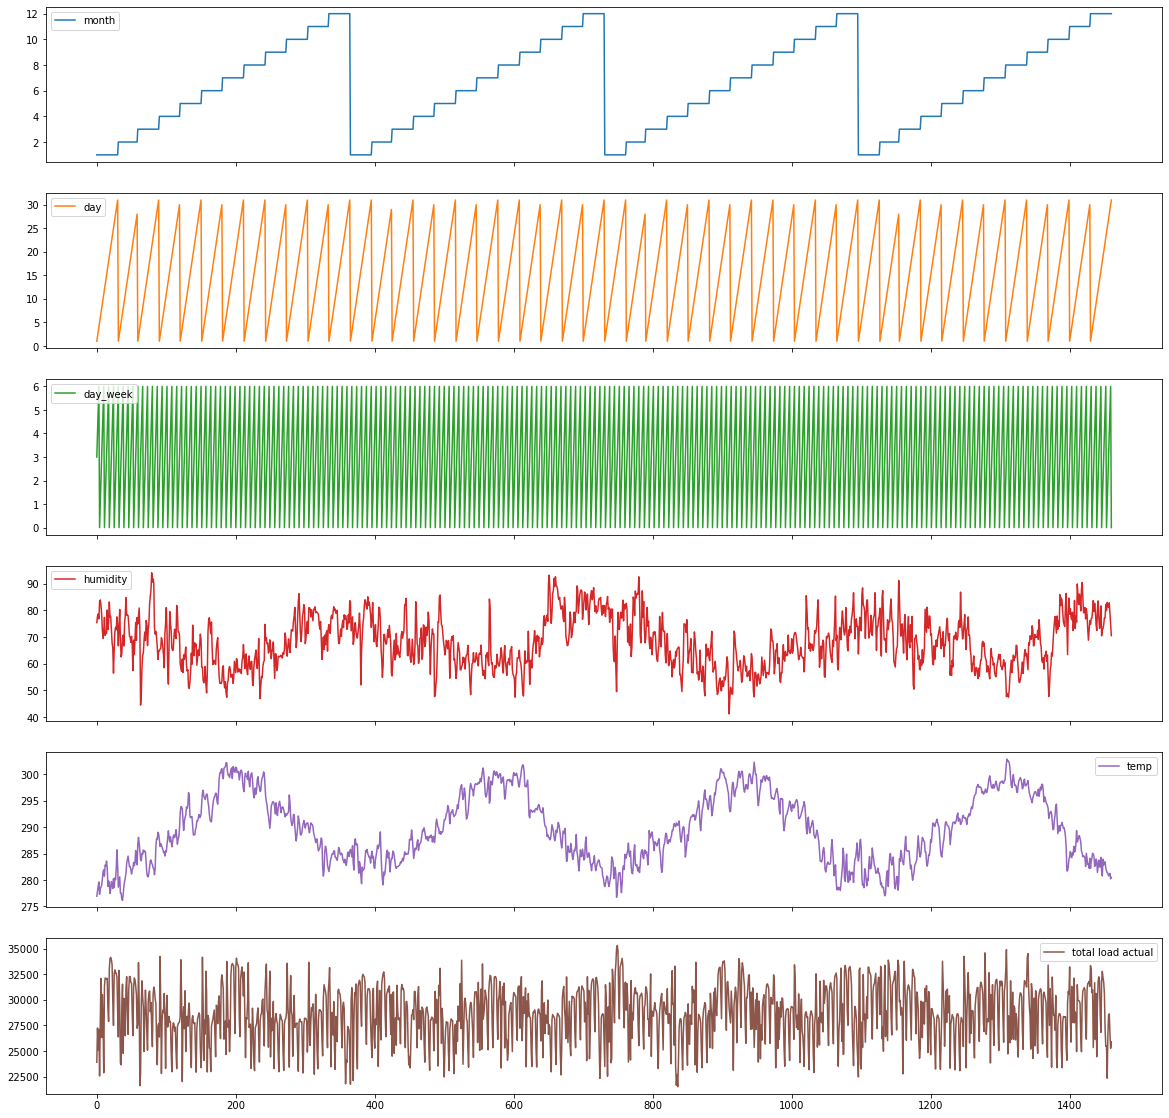

In [95]:
# plot for each column
df.plot(figsize=(20, 20), subplots=True)

## Remove outliers in the energy consumption column

For the energy consumption, the outliers are detected using a rolling basis.

Same as before, the threshold for classifying an outlier is defined as 2 times the standard deviation.

In [96]:
# code from https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d

# window size = 14 days
def basic_filter(data, mode='rolling', window=14, threshold=2):
    """Basic Filter.
    
    Mark as outliers the points that are out of the interval:
    (mean - threshold * std, mean + threshold * std ).
    
    Parameters
    ----------
    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series : pandas.DataFrame
        Original series and marked outliers.
    """
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

In [97]:
# check if the energy value is an outlier
energy_outliers = basic_filter(df['total load actual'])

# add the outlier column to the df_no_outliers dataframe
df['load_outlier'] = energy_outliers['Outliers']

df

,month,day,day_week,humidity,temp,total load actual,load_outlier
0,1,1,3,75.391667,276.928845,23896.750000,0
1,1,2,4,77.833333,277.897585,27251.291667,0
2,1,3,5,78.591667,278.817864,25110.666667,0
3,1,4,6,76.766667,279.630031,27112.625000,0
4,1,5,0,83.322222,277.302399,22559.444444,0
...,...,...,...,...,...,...,...
1456,12,27,3,81.030556,280.774514,28532.208333,0
1457,12,28,4,82.788889,280.972111,28637.750000,0
1458,12,29,5,78.708333,281.231583,26636.750000,0
1459,12,30,6,74.272222,280.229097,25263.916667,0


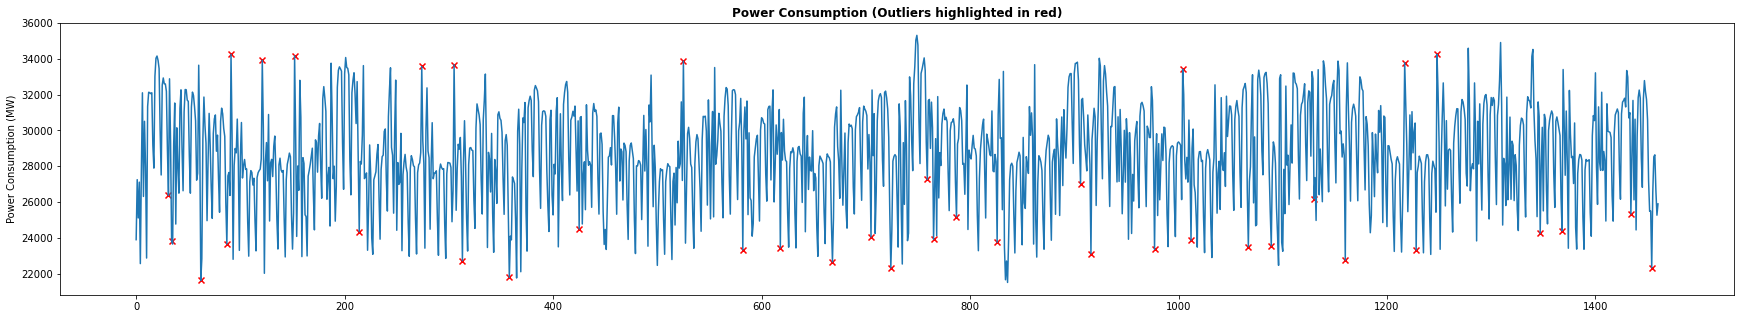

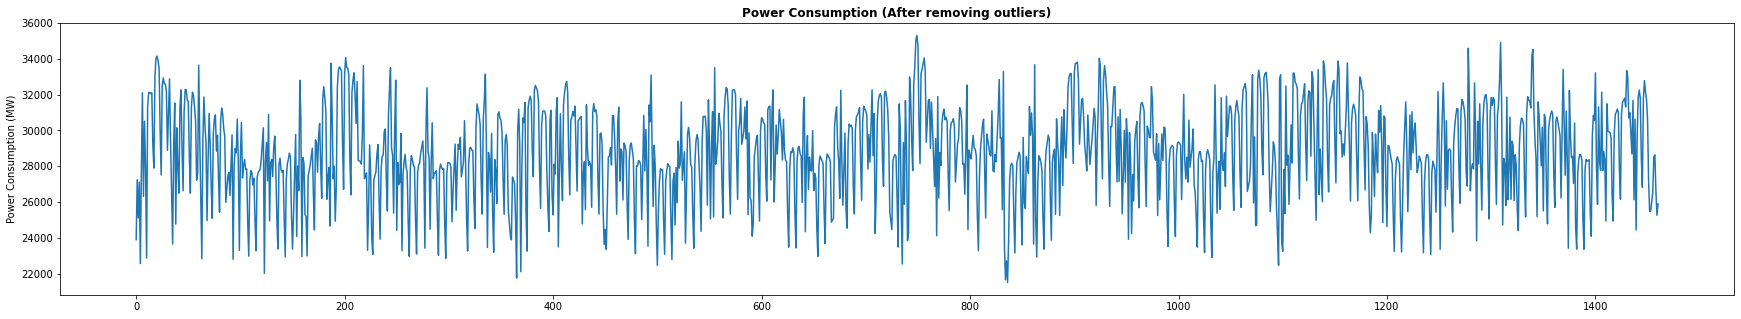

In [98]:
# show the outlier in plot
plt.figure(figsize=(30, 5))
plt.plot(df["total load actual"])

outliers = df["load_outlier"]
plt.scatter(df.loc[outliers == 1].index, df.loc[outliers == 1]["total load actual"], c = 'red', marker="x")
plt.ylabel("Power Consumption (MW)")
plt.title("Power Consumption (Outliers highlighted in red)", fontweight="bold")
plt.show()

# select only non-outlier data
df = df.loc[df['load_outlier'] == 0]

# show data after removing outlier
plt.figure(figsize=(30, 5))
plt.plot(df["total load actual"])
plt.ylabel("Power Consumption (MW)")
plt.title("Power Consumption (After removing outliers)", fontweight="bold")
plt.show()


### Remove noise using Fourier Transform

In [99]:
if DENOISE:
    def fft_denoiser(x, n_components, to_real=True):
        """Fast fourier transform denoiser.
        
        Denoises data using the fast fourier transform.
        
        Parameters
        ----------
        x : numpy.array
            The data to denoise.
        n_components : int
            The value above which the coefficients will be kept.
        to_real : bool, optional, default: True
            Whether to remove the complex part (True) or not (False)
            
        Returns
        -------
        clean_data : numpy.array
            The denoised data.
            
        References
        ----------
        .. [1] Steve Brunton - Denoising Data with FFT[Python]
        https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
        
        """
        n = len(x)
        
        # compute the fft
        fft = np.fft.fft(x, n)
        
        # compute power spectrum density
        # squared magnitud of each fft coefficient
        PSD = fft * np.conj(fft) / n
        
        # keep high frequencies
        _mask = PSD > n_components
        fft = _mask * fft
        
        # inverse fourier transform
        clean_data = np.fft.ifft(fft)
        
        if to_real:
            clean_data = clean_data.real
        
        return clean_data

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


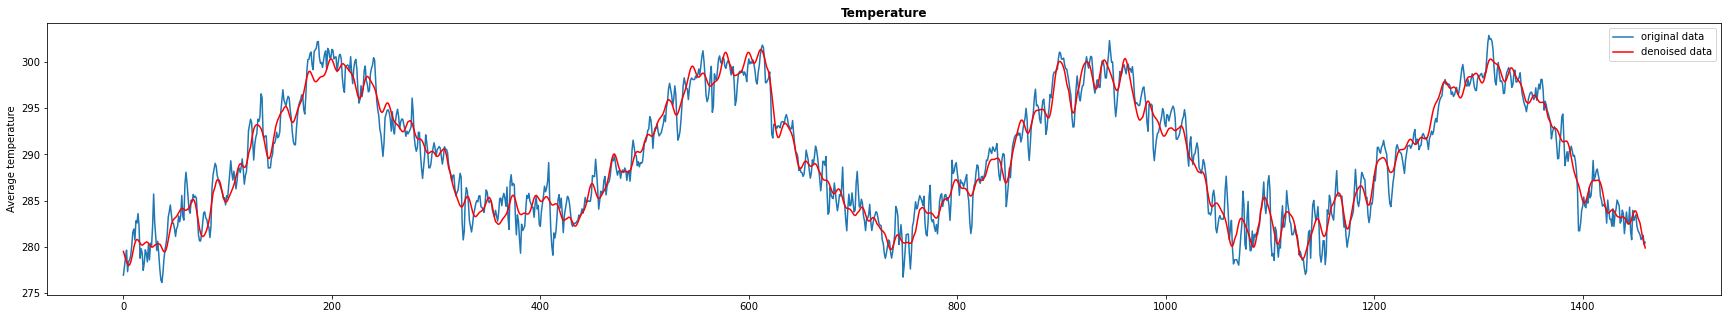

<ipython-input-100-9ce47353023d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['denoised_data_humidity'] = denoised_humidity


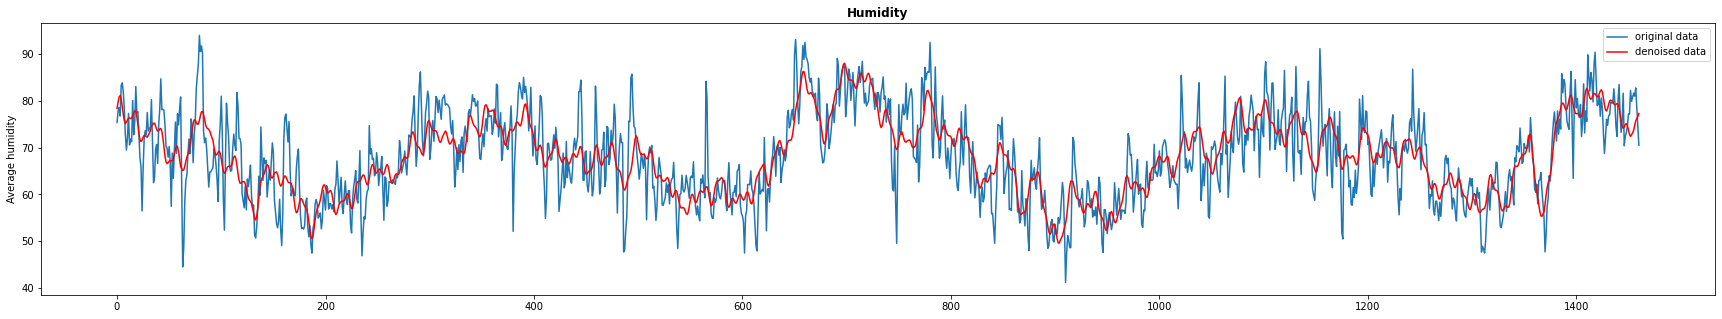

<ipython-input-100-9ce47353023d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['denoised_data_load'] = denoised_load


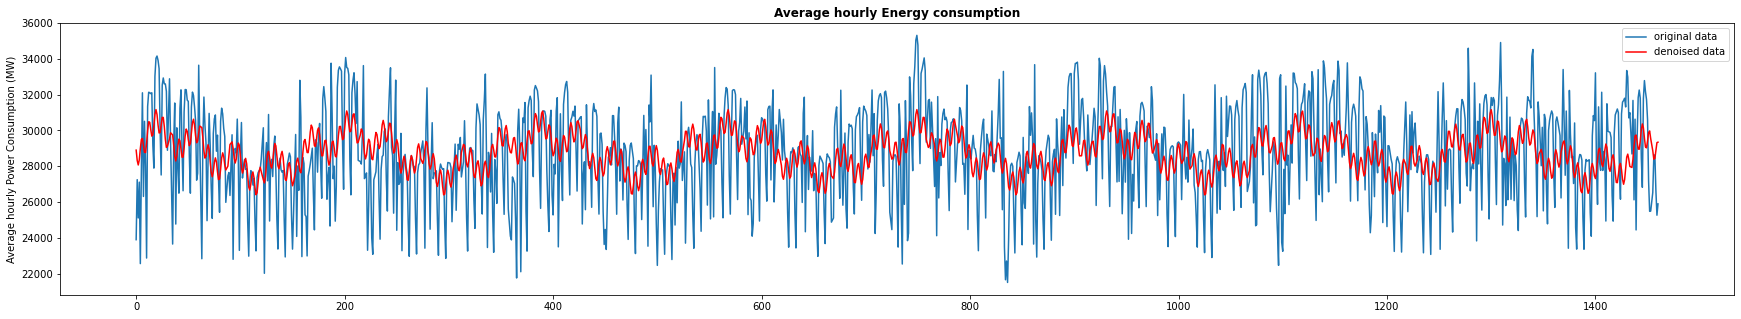

In [100]:
if DENOISE:
    # remove noise in temperature 
    denoised_temp = fft_denoiser(df['temp'], 25)
    df.loc[:, 'denoised_data_temp'] = denoised_temp

    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['temp'], label='original data')
    plt.plot(df['denoised_data_temp'], color='r', label = "denoised data")
    plt.ylabel("Average temperature")
    plt.title("Temperature", fontweight="bold")
    plt.legend()
    plt.show()

    # remove noise in humidity 
    denoised_humidity = fft_denoiser(df['humidity'],300)
    df['denoised_data_humidity'] = denoised_humidity
    df

    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['humidity'], label='original data')
    plt.plot(df['denoised_data_humidity'], color='r', label = "denoised data")
    plt.ylabel("Average humidity")
    plt.title("Humidity", fontweight="bold")
    plt.legend()
    plt.show()

    # remove noise in energy consumption 
    denoised_load = fft_denoiser(df['total load actual'], 145000000)
    df['denoised_data_load'] = denoised_load
    df


    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['total load actual'], label='original data')
    plt.plot(df['denoised_data_load'], color='r', label = "denoised data")
    plt.ylabel("Average hourly Power Consumption (MW)")
    plt.title("Average hourly Energy consumption", fontweight="bold")
    plt.legend()
    plt.show()

In [101]:
if DENOISE:
    df = df.drop(['total load actual', 'temp', 'humidity', 'load_outlier'], axis=1)
    df

In [102]:
if not DENOISE:
    df = df.drop(['load_outlier'], axis=1)
    df

In [103]:
df_clean = df.copy()
df_clean = df_clean.reset_index(drop=True)
df_clean


,month,day,day_week,denoised_data_temp,denoised_data_humidity,denoised_data_load
0,1,1,3,279.491020,78.392197,28900.448644
1,1,2,4,279.110262,79.736353,28323.259655
2,1,3,5,278.727997,80.838707,28071.530600
3,1,4,6,278.373749,81.150555,28359.995469
4,1,5,0,278.102647,80.417314,28988.436406
...,...,...,...,...,...,...
1417,12,27,3,281.913990,74.807485,28396.755304
1418,12,28,4,281.296557,75.699231,28438.090703
1419,12,29,5,280.748508,76.242194,28887.109770
1420,12,30,6,280.280294,76.657099,29322.482935


In [104]:
# add a column for the energy consumption, but swifted a day up
df_clean['label'] = df_clean.iloc[:, -1]
df_clean['label'] = df_clean['label'].shift(-1)

# delete the last row
df_clean = df_clean.iloc[:-1, :]
df_clean

,month,day,day_week,denoised_data_temp,denoised_data_humidity,denoised_data_load,label
0,1,1,3,279.491020,78.392197,28900.448644,28323.259655
1,1,2,4,279.110262,79.736353,28323.259655,28071.530600
2,1,3,5,278.727997,80.838707,28071.530600,28359.995469
3,1,4,6,278.373749,81.150555,28359.995469,28988.436406
4,1,5,0,278.102647,80.417314,28988.436406,29501.673994
...,...,...,...,...,...,...,...
1416,12,26,2,282.554654,73.686217,28866.668457,28396.755304
1417,12,27,3,281.913990,74.807485,28396.755304,28438.090703
1418,12,28,4,281.296557,75.699231,28438.090703,28887.109770
1419,12,29,5,280.748508,76.242194,28887.109770,29322.482935


### Standardize the data

In [105]:
# standardize the data so that all values lie between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df_clean = pd.DataFrame(scaler.fit_transform(df_clean), index=df_clean.index, columns=df_clean.columns)

## Split the dataset to training, validation and test set

In [106]:
# split the data into 70% training, 10% validation and 20% test set
# manually split the data to avoid shuffling the data
train_idx = int(len(df_clean)*0.7)
validation_idx = int(len(df_clean)*0.8)


train_data = df_clean.iloc[:train_idx]
validation_data = df_clean.iloc[train_idx:validation_idx]
test_data = df_clean.iloc[validation_idx:]

print("training set sample size is", len(train_data))
print("validation set sample size is", len(validation_data))
print("test set sample size is", len(test_data))

print("total sample size is", len(train_data)+ len(validation_data) +len(test_data))

training set sample size is 994
validation set sample size is 142
test set sample size is 285
total sample size is 1421


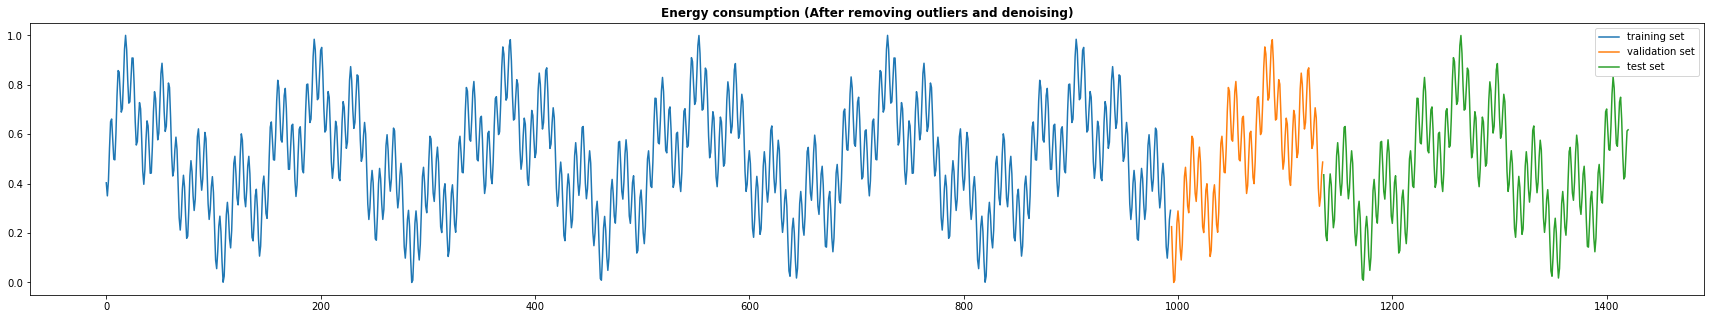

In [107]:
plt.figure(figsize=(30, 5))
plt.plot(train_data['label'], label='training set')
plt.plot(np.arange(train_data.shape[0], train_data.shape[0] + validation_data.shape[0]), validation_data['label'], label='validation set')
plt.plot(np.arange(train_data.shape[0] + validation_data.shape[0], train_data.shape[0] + validation_data.shape[0]+test_data.shape[0]), test_data['label'], label='test set')
plt.legend()
plt.title('Energy consumption (After removing outliers and denoising)', fontweight='bold')
plt.show()

## Give each instance a sequence of observations

In [108]:
# functions to create sequence of observations
# each instance will have number of observations = sequence_length

# code adapted from https://www.youtube.com/watch?v=jR0phoeXjrc

# function to create list, with each element containing sequence_length of observations
def create_feature(input_data: pd.DataFrame, sequence_length):

    feature = []
    data_size = len(input_data)

    input_data = input_data.iloc[:, :-1]
    
    for i in range(data_size - sequence_length):
        
        sequence = input_data[i:i+sequence_length]

        feature.append(sequence)

    return feature

# function to create labels for each element of the create_feature list
def create_label(input_data: pd.DataFrame, target_column, sequence_length):

    labels = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        # sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        labels.append(label)

    return labels

In [109]:
SEQUENCE_LENGTH = 7

# lag the training set
train_feature = create_feature(train_data, sequence_length = SEQUENCE_LENGTH)
train_label = create_label(train_data, "label", sequence_length = SEQUENCE_LENGTH)

# lag the validation set
validation_feature = create_feature(validation_data, sequence_length=SEQUENCE_LENGTH)
validation_label = create_label(validation_data, "label", sequence_length=SEQUENCE_LENGTH)

# lag the test set
test_feature = create_feature(test_data, sequence_length=SEQUENCE_LENGTH)
test_label = create_label(test_data, "label", sequence_length=SEQUENCE_LENGTH)

In [110]:
print("Length of train_feature is ", str(len(train_feature)))
print("Length of train_label is ", str(len(train_label)))
print("Length of validation_feature is ", str(len(validation_feature)))
print("Length of validation_label is ", str(len(validation_label)))
print("Length of test_feature is ", str(len(test_feature)))
print("Length of test_label is ", str(len(test_label)))


Length of train_feature is  987
Length of train_label is  987
Length of validation_feature is  135
Length of validation_label is  135
Length of test_feature is  278
Length of test_label is  278


### Check whether it is running on CPU or GPU

In [111]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## MLP

Since MLP only takes a 1D tensor for the input, the tensors have to be flattened to fit into MLP model

In [112]:
import torch
# convert the training_feature list to tensor
X_train_MLP = torch.tensor(np.array(train_feature), dtype=torch.float)
# flatten the tensor
X_train_MLP = torch.flatten(X_train_MLP, start_dim=1)
print("The shape of the X_train_MLP tensor is ", str(X_train_MLP.shape))

# convert the training_label list to tensor
y_train_MLP = torch.FloatTensor(train_label)
print("The shape of the y_train_MLP tensor is ", str(y_train_MLP.shape))

# convert the validation_feature list to tensor
X_validation_MLP = torch.tensor(np.array(validation_feature), dtype=torch.float)
# flatten the tensor
X_validation_MLP = torch.flatten(X_validation_MLP, start_dim=1)
print("The shape of the X_validation_MLP tensor is ", str(X_validation_MLP.shape))

# convert the training_label list to tensor
y_validation_MLP = torch.FloatTensor(validation_label)
print("The shape of the y_validation_MLP tensor is ", str(y_validation_MLP.shape))

# convert the test_feature list to tensor
X_test_MLP = torch.tensor(np.array(test_feature), dtype=torch.float)
# flatten the tensor
X_test_MLP = torch.flatten(X_test_MLP, start_dim=1)
print("The shape of the X_test_MLP tensor is ", str(X_test_MLP.shape))

# convert the test_label list to tensor
y_test_MLP = torch.FloatTensor(test_label)
print("The shape of the y_test_MLP tensor is ", str(y_test_MLP.shape))

The shape of the X_train_MLP tensor is  torch.Size([987, 42])
The shape of the y_train_MLP tensor is  torch.Size([987])
The shape of the X_validation_MLP tensor is  torch.Size([135, 42])
The shape of the y_validation_MLP tensor is  torch.Size([135])
The shape of the X_test_MLP tensor is  torch.Size([278, 42])
The shape of the y_test_MLP tensor is  torch.Size([278])


## Simple MLP 

In [113]:
# create a MLP class
# code from week 2 lab

class MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

In [114]:
# get an instance of the MLP
mlp_model = MLP(input_size = X_train_MLP.shape[1], hidden_dim = 40, output_size=1)    # shape of X_train_MLP = (992, 12)

In [115]:
# define some parameters for the MLP
lr = 0.01    # learning rate
n_epoch = 100   # number of epochs
momentum = 0.95  # momentum term

criterion = nn.MSELoss()    # specify loss function as mean-squared error
optimizer = torch.optim.SGD(mlp_model.parameters(), lr, momentum)   # optimise using stochastic gradient descent

In [116]:
mlp_model.train()  # enter train mode

for epoch in range(n_epoch):
    optimizer.zero_grad()   # reset gradient
    y_pred = mlp_model(X_train_MLP)     # get predicted value
    loss = criterion(y_pred.squeeze(), y_train_MLP)     # calculate the loss   
    loss.backward()     # backpropagation
    optimizer.step()    # update the parameters

    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

Epoch 0/100 - Loss: 0.3754502534866333
Epoch 10/100 - Loss: 0.10372907668352127
Epoch 20/100 - Loss: 0.09026192128658295
Epoch 30/100 - Loss: 0.09986203163862228
Epoch 40/100 - Loss: 0.04104972258210182
Epoch 50/100 - Loss: 0.06237225607037544
Epoch 60/100 - Loss: 0.03558216616511345
Epoch 70/100 - Loss: 0.04270569607615471
Epoch 80/100 - Loss: 0.03275805339217186
Epoch 90/100 - Loss: 0.033702440559864044


In [117]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation_MLP)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_MLP)    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.02771296724677086


In [172]:
# test the loss on training set
y_pred_best = mlp_model(X_validation_MLP)
print('The RMSE on validation set is ', mean_squared_error(y_pred_best.detach().numpy(), y_validation_MLP, squared=False))  


The RMSE on validation set is  0.1664721


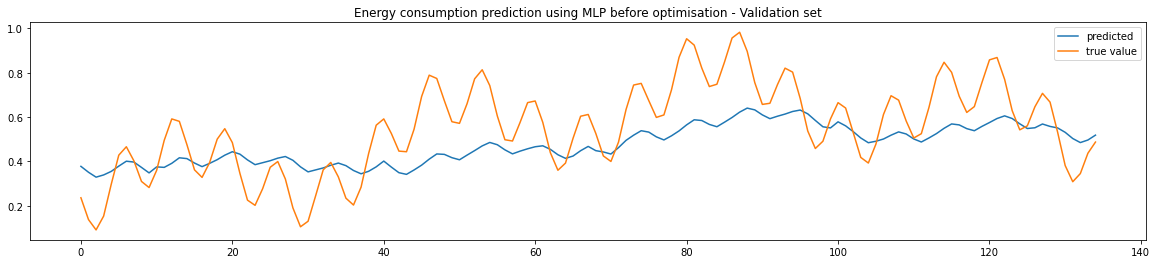

In [118]:
# compare the predicted and true value
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_validation_MLP, label='true value')
plt.title("Energy consumption prediction using MLP before optimisation - Validation set")
plt.legend()
plt.show()

### Tuning hyperparameters with grid search and cross validation

In [119]:
# time series cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10, test_size=20, gap = 10)

In [120]:
X_train_MLP.shape

torch.Size([987, 42])

In [121]:
y_train_MLP_2D = y_train_MLP[:, None]
y_train_MLP_2D.shape

torch.Size([987, 1])

In [122]:
# new instance for MLP
MLP_GS = MLP(input_size = X_train_MLP.shape[1], hidden_dim = 40, output_size=1)

net_mlp = NeuralNetRegressor(module = MLP_GS, train_split=False)  

from sklearn.model_selection import GridSearchCV
params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 30],
        'optimizer': [torch.optim.SGD, torch.optim.Adam]}

gs = GridSearchCV(net_mlp, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)
gs.fit(X_train_MLP, y_train_MLP_2D)
print(gs.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0742  0.0107
      2        0.0521  0.0132
      3        0.0509  0.0120
      4        0.0507  0.0114
      5        0.0506  0.0112
      6        0.0505  0.0114
      7        0.0504  0.0115
      8        0.0503  0.0102
      9        0.0503  0.0106
     10        0.0502  0.0102
     11        0.0501  0.0100
     12        0.0500  0.0102
     13        0.0499  0.0104
     14        0.0498  0.0106
     15        0.0498  0.0107
     16        0.0497  0.0106
     17        0.0496  0.0102
     18        0.0495  0.0108
     19        0.0494  0.0103
     20        0.0494  0.0100
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0728  0.0096
      2        0.0515  0.0111
      3        0.0503  0.0105
      4        0.0501  0.0102
      5        0.0500  0.0106
      6        0.0499  0.0109
      7        0.0498  0.0102
      8        0.0497  0.0109
      9        0.0496  0.0106
     10   

In [123]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs.best_params_, -gs.best_score_))
gs.best_params_

Result of grid search returns the best model as {'lr': 0.01, 'max_epochs': 20, 'optimizer': <class 'torch.optim.adam.Adam'>} with a mean squared error of 0.012507


{'lr': 0.01, 'max_epochs': 20, 'optimizer': torch.optim.adam.Adam}

The root mean squared error for Training set is  0.11324717
The mean absolute error for Training set is  0.093673505


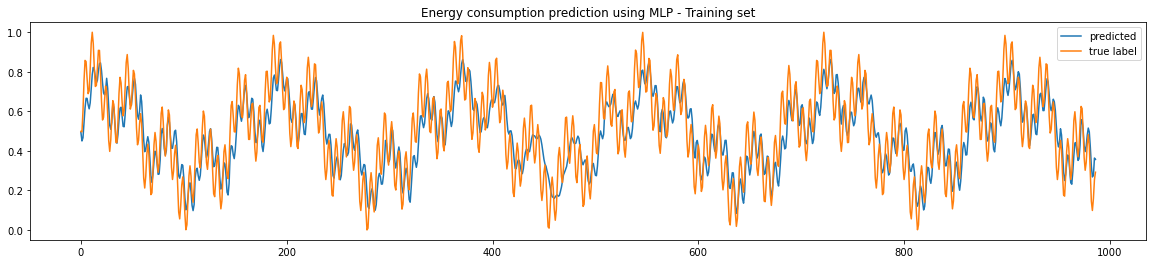

The root mean squared error for Validation set is  0.10883119
The mean absolute error for Validation set is  0.090697154


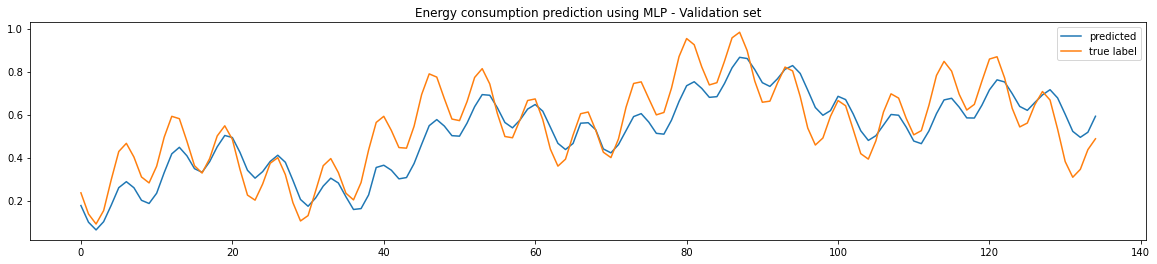

The root mean squared error for Test set is  0.12660724
The mean absolute error for Test set is  0.102830105


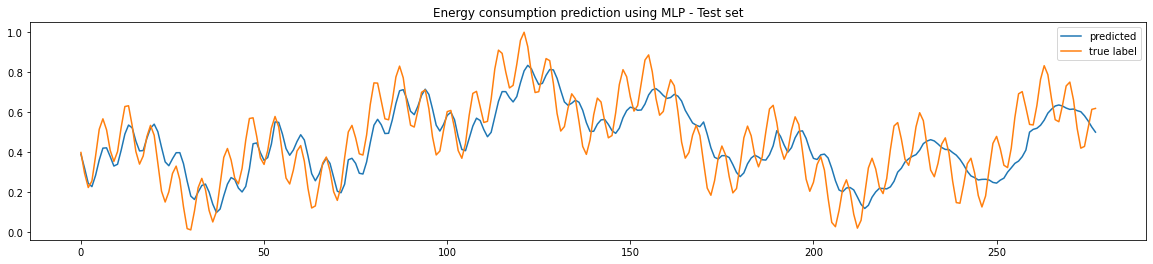

In [158]:
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_MLP, y_validation_MLP, y_test_MLP]
features = [X_train_MLP, X_validation_MLP, X_test_MLP]

for i in range(len(true_label)):
    y_pred = gs.predict(features[i])
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared=False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using MLP - ' + str(set[i]))
    plt.legend()
    plt.show()


In [126]:
# # save the best MLP model from grid search
# from joblib import dump, load
# dump(gs.best_estimator_, 'MLP.pkl')

In [83]:
load('MLP.pkl')

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP(
    (fc1): Linear(in_features=42, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

## RNN

The input tensor should not be flattened for RNN, because RNN takes into account the sequence length. Recreate the training, validation and test set for the RNN.

In [127]:
# create tensor containing the lagged feature for training set 
train_feature = np.array([np.array(xi) for xi in train_feature])    # convert the list of list to a numpy array
X_train_RNN = torch.Tensor(train_feature)   # create the tensor

# create tensor for the label of training set 
y_train_RNN = torch.Tensor(np.array(train_label))   # convert the list of label to an numpy array, then to a tensor
y_train_RNN = torch.unsqueeze(y_train_RNN, 1)   # add a dimension of size one to the tensor

# create tensor containing the lagged feature for validation set 
X_validation_RNN = np.array([np.array(xi) for xi in validation_feature])    # convert the list of list to a numpy array
X_validation_RNN = torch.Tensor(X_validation_RNN)   # create the tensor

# create tensor for the label of validation set 
y_validation_RNN = torch.Tensor(np.array(validation_label))   # convert the list of label to an numpy array, then to a tensor
y_validation_RNN = torch.unsqueeze(y_validation_RNN, 1)  # add a dimension of size one to the tensor

# create tensor containing the lagged feature for test set 
X_test_RNN = np.array([np.array(xi) for xi in test_feature])      # convert the list of list to a numpy array
X_test_RNN = torch.Tensor(X_test_RNN)    # create the tensor

# create tensor for the label of test set 
y_test_RNN = torch.Tensor(np.array(test_label))  # convert the list of label to an numpy array, then to a tensor
y_test_RNN = torch.unsqueeze(y_test_RNN, 1)  # add a dimension of size one to the tensor

In [128]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32
# create batched dataset
train_RNN = TensorDataset(X_train_RNN, y_train_RNN)
train_loader_RNN = DataLoader(train_RNN, batch_size = BATCH_SIZE, shuffle=False, drop_last=True)

validation_RNN = TensorDataset(X_validation_RNN, y_validation_RNN)
validation_loader_RNN = DataLoader(validation_RNN, batch_size = BATCH_SIZE, shuffle=False, drop_last=True)

test_RNN = TensorDataset(X_test_RNN, y_test_RNN)
test_loader_RNN = DataLoader(test_RNN, batch_size = BATCH_SIZE, shuffle=False, drop_last=True)

# check the shapes of the input and output tensors in training set
X, y = next(iter(train_loader_RNN))
print(X.shape)
print(y.shape)

# check the shapes of the input and output tensors in validation set
X, y = next(iter(validation_loader_RNN))
print(X.shape)
print(y.shape)

# check the shapes of the input and output tensors in test set
X, y = next(iter(test_loader_RNN))
print(X.shape)
print(y.shape)

torch.Size([32, 7, 6])
torch.Size([32, 1])
torch.Size([32, 7, 6])
torch.Size([32, 1])
torch.Size([32, 7, 6])
torch.Size([32, 1])


In [129]:
# create RNN class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [130]:
# Instantiate the model with hyperparameters
RNN_model = RNN(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

# Define hyperparameters
n_epochs = 50
lr=0.01
momentum = 0.95

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(RNN_model.parameters(), lr=lr, momentum=momentum)

In [131]:
RNN_model.train()    # training mode

# Training Run
for epoch in range(1, n_epochs + 1):
    for X, y in train_loader_RNN:
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        # features_reshaped = features.view(features.shape[0], -1, features.shape[1])     # change the input tensor to (batch size, sequence length, input_size)
        output = RNN_model(X)
        output = output.to(device)

        loss = criterion(output, y)
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/50............. Loss: 0.0111
Epoch: 20/50............. Loss: 0.0009
Epoch: 30/50............. Loss: 0.0007
Epoch: 40/50............. Loss: 0.0004
Epoch: 50/50............. Loss: 0.0004


In [132]:
RNN_model.eval()    # enter evaluation mode

y_pred = RNN_model(X_validation_RNN)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_RNN.squeeze())    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.0006556513253599405


In [168]:
# test the loss on training set
y_pred_best = RNN_model(X_validation_RNN)
print('The RMSE on validation set is ', mean_squared_error(y_pred_best.detach().numpy(), y_validation_MLP, squared=False))  


The RMSE on validation set is  0.02560569


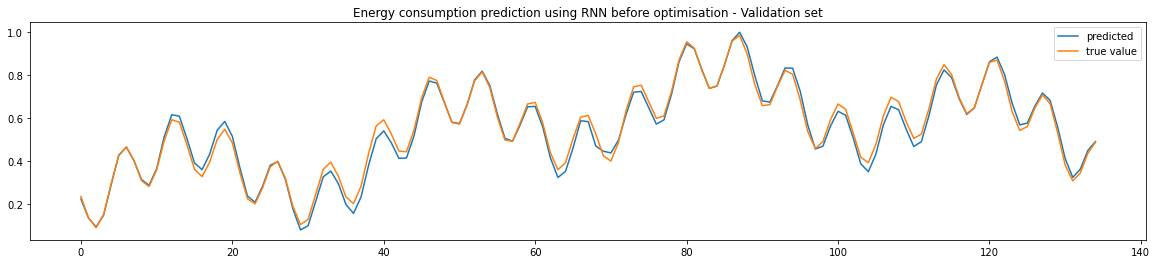

In [133]:
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_validation_RNN, label='true value')
plt.title("Energy consumption prediction using RNN before optimisation - Validation set")
plt.legend()
plt.show()

### Tuning hyperparameters with grid search and cross validation

In [134]:
# time series cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10, test_size=20, gap = 10)

In [135]:
X_train_RNN.shape

torch.Size([987, 7, 6])

In [136]:
y_train_RNN.shape

torch.Size([987, 1])

In [137]:
# new instance for RNN
RNN_GS = RNN(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

net_rnn = NeuralNetRegressor(module = RNN_GS, train_split=False)  

from sklearn.model_selection import GridSearchCV
params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'batch_size': [16, 32]}

gs_RNN = GridSearchCV(net_rnn, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)
gs_RNN.fit(X_train_RNN, y_train_RNN)
print(gs_RNN.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0698  0.0626
      2        0.0438  0.0623
      3        0.0418  0.0623
      4        0.0401  0.0550
      5        0.0385  0.0578
      6        0.0371  0.0605
      7        0.0358  0.0585
      8        0.0346  0.0585
      9        0.0335  0.0586
     10        0.0324  0.0608
     11        0.0314  0.0583
     12        0.0305  0.0615
     13        0.0296  0.0592
     14        0.0287  0.0597
     15        0.0280  0.0596
     16        0.0272  0.0578
     17        0.0266  0.0588
     18        0.0260  0.0596
     19        0.0254  0.0591
     20        0.0249  0.0615
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0687  0.0599
      2        0.0435  0.0601
      3        0.0415  0.0585
      4        0.0398  0.0583
      5        0.0382  0.0582
      6        0.0368  0.0620
      7        0.0355  0.0565
      8        0.0343  0.0587
      9        0.0332  0.0600
     10   

In [138]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs_RNN.best_params_, -gs_RNN.best_score_))

Result of grid search returns the best model as {'batch_size': 16, 'lr': 0.1, 'max_epochs': 40, 'optimizer': <class 'torch.optim.sgd.SGD'>} with a mean squared error of 0.001479


In [139]:
# test the loss on training set
y_pred_best = gs_RNN.predict(X_validation_RNN)
mean_squared_error(y_pred_best, y_validation_RNN)  

0.0047698338

The root mean squared error for Training set is  0.065433905
The mean absolute error for Training set is  0.054054383


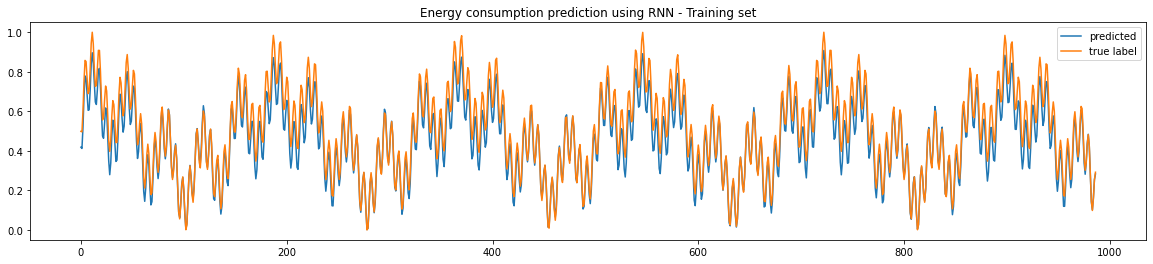

The root mean squared error for Validation set is  0.069063984
The mean absolute error for Validation set is  0.060465686


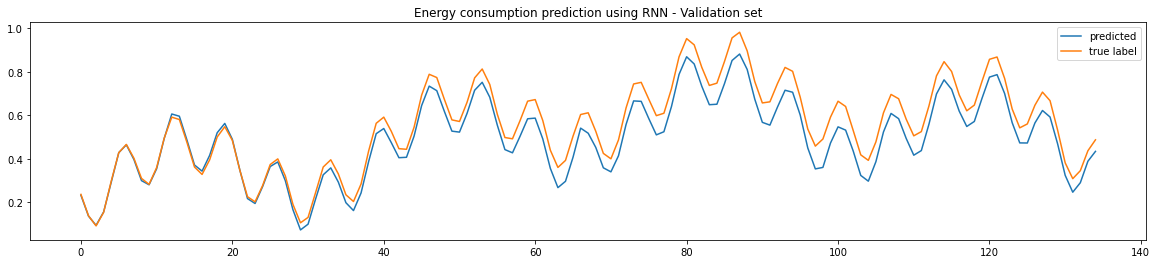

The root mean squared error for Test set is  0.056971084
The mean absolute error for Test set is  0.043810844


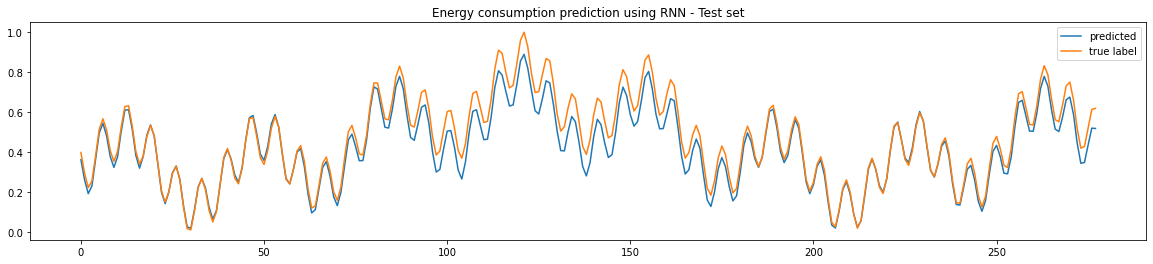

In [153]:
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_RNN, y_validation_RNN, y_test_RNN]
features = [X_train_RNN, X_validation_RNN, X_test_RNN]

for i in range(len(true_label)):
    y_pred = gs_RNN.predict(features[i])
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared = False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using RNN - ' + str(set[i]))
    plt.legend()
    plt.show()


In [141]:
# # save the best MLP model from grid search
# dump(gs_RNN.best_estimator_, 'RNN.pkl')

### LSTM

In [142]:
# define a LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state for first input with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.lstm(x, (h0, c0))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [143]:
# Instantiate the model with hyperparameters
LSTM_model = LSTM(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = LSTM_model.to(device)

# Define hyperparameters
n_epochs = 50
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [144]:
LSTM_model.train()    # training mode

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch       
    for X, y in train_loader_RNN:
        output = LSTM_model(X)
        output = output.to(device)
        loss = criterion(output, y)
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/50............. Loss: 0.0255
Epoch: 20/50............. Loss: 0.0235
Epoch: 30/50............. Loss: 0.0194
Epoch: 40/50............. Loss: 0.0188
Epoch: 50/50............. Loss: 0.0184


In [145]:
LSTM_model.eval()    # enter evaluation mode

y_pred = LSTM_model(X_validation_RNN)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_RNN.squeeze())    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.01682942733168602


In [167]:
# test the loss on training set
y_pred_best = LSTM_model(X_validation_RNN)
print('The RMSE on validation set is ', mean_squared_error(y_pred_best.detach().numpy(), y_validation_RNN, squared=False))


The RMSE on validation set is  0.12972827


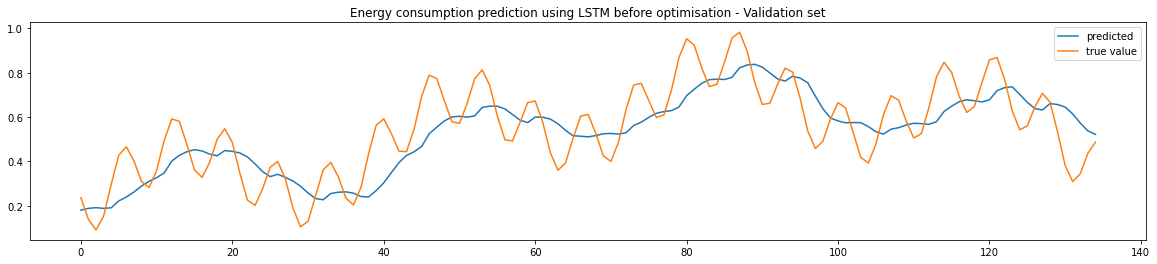

In [146]:
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_validation_RNN, label='true value')
plt.title("Energy consumption prediction using LSTM before optimisation - Validation set")
plt.legend()
plt.show()

### Tuning hyperparameters with grid search and cross validation

In [147]:
# time series cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10, test_size=20, gap = 10)

In [148]:
# new instance for LSTM
LSTM_GS = RNN(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

net_lstm = NeuralNetRegressor(module = LSTM_GS, train_split=False)  

from sklearn.model_selection import GridSearchCV
params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'batch_size': [16, 32]}

gs_LSTM = GridSearchCV(net_lstm, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)
gs_LSTM.fit(X_train_RNN, y_train_RNN)
print(gs_LSTM.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0908  0.0634
      2        0.0443  0.0624
      3        0.0410  0.0640
      4        0.0383  0.0692
      5        0.0360  0.0672
      6        0.0340  0.0704
      7        0.0323  0.0710
      8        0.0308  0.0729
      9        0.0296  0.0682
     10        0.0284  0.0673
     11        0.0275  0.0679
     12        0.0266  0.0648
     13        0.0259  0.0671
     14        0.0253  0.0594
     15        0.0247  0.0589
     16        0.0243  0.0594
     17        0.0238  0.0584
     18        0.0235  0.0644
     19        0.0231  0.0626
     20        0.0229  0.0587
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0889  0.0589
      2        0.0436  0.0622
      3        0.0403  0.0615
      4        0.0377  0.0589
      5        0.0354  0.0597
      6        0.0335  0.0617
      7        0.0319  0.0594
      8        0.0304  0.0585
      9        0.0292  0.0581
     10   

In [149]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs_LSTM.best_params_, -gs_LSTM.best_score_))

Result of grid search returns the best model as {'batch_size': 16, 'lr': 0.1, 'max_epochs': 40, 'optimizer': <class 'torch.optim.sgd.SGD'>} with a mean squared error of 0.001468


In [150]:
# test the loss on training set
y_pred_best = gs_LSTM.predict(X_validation_RNN)
mean_squared_error(y_pred_best, y_validation_RNN)  

0.004805643

The root mean squared error for Training set is  0.066332944
The mean absolute error for Training set is  0.054699227


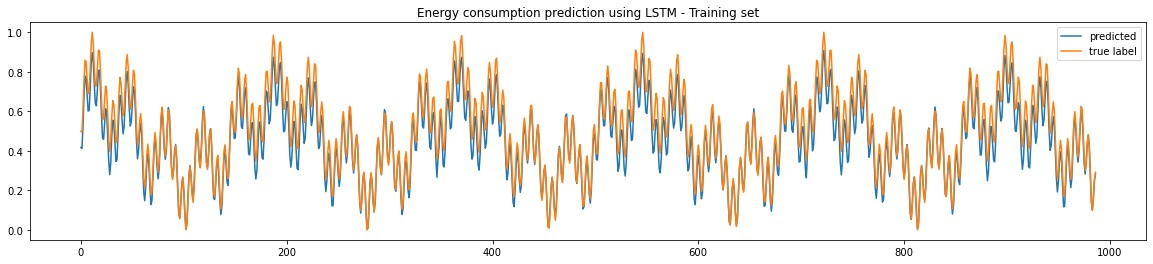

The root mean squared error for Validation set is  0.06932274
The mean absolute error for Validation set is  0.06058621


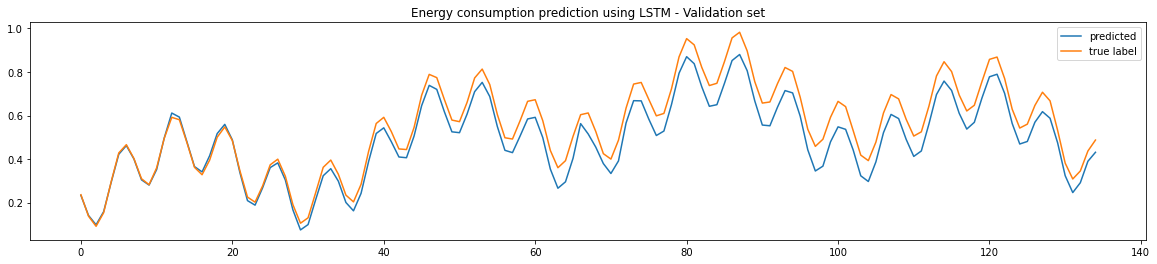

The root mean squared error for Test set is  0.05812359
The mean absolute error for Test set is  0.044711463


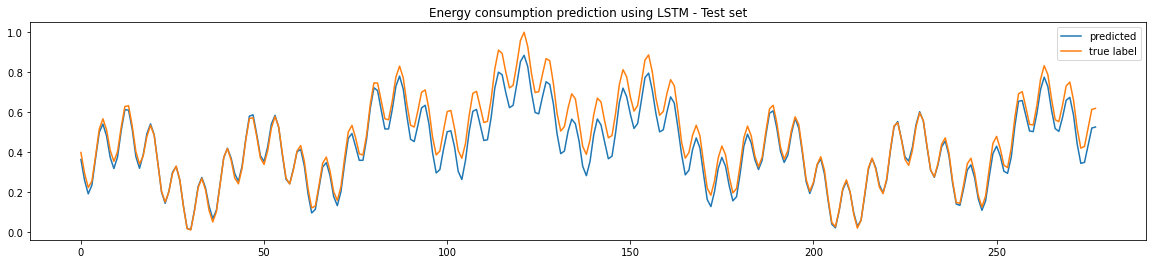

In [155]:
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_RNN, y_validation_RNN, y_test_RNN]
features = [X_train_RNN, X_validation_RNN, X_test_RNN]

for i in range(len(true_label)):
    y_pred = gs_LSTM.predict(features[i])
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared=False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using LSTM - ' + str(set[i]))
    plt.legend()
    plt.show()


In [152]:
# # save the best MLP model from grid search
# dump(gs_LSTM.best_estimator_, 'LSTM.pkl')